**Install Required Libraries**

In [ ]:
!pip install openpyxl
# Install required libraries
!pip install kagglehub torch torchvision Pillow tqdm scikit-image opencv-python pandas matplotlib torchsummary xlsxwriter -q

**Import libraries**

In [ ]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import kagglehub
from torch.amp import GradScaler, autocast
import torch.nn.functional as F
from skimage.metrics import structural_similarity as ssim
import shutil
import multiprocessing
from concurrent.futures import ThreadPoolExecutor, as_completed
import cv2
import torchvision.models as models
from torchsummary import summary
import skimage.measure
from skimage.morphology import skeletonize, remove_small_objects, erosion, dilation, disk
from skimage.filters import threshold_otsu, threshold_local
import gc
import warnings
import zipfile
from datetime import datetime

**Configuration**

In [ ]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available, else CPU
IMG_SIZE = 256 # Input image size (256x256 pixels)
BATCH_SIZE = 4 # Batch size for training
ACCUMULATION_STEPS = 2 # Gradient accumulation steps
EPOCHS = 1 # Number of training epochs
LR = 0.0001 # Learning rate
AUX_DIM = 2 # Dimension of auxiliary data (age and sex)
L1_LAMBDA = 20 # Weight for L1 loss component
GAN_LAMBDA = 1.0 # Weight for GAN loss component
PERCEPTUAL_LAMBDA = 10.0 # Weight for perceptual loss component
MSSSIM_LAMBDA = 50 # Weight for MS-SSIM loss component
EDGE_LAMBDA = 30 # Weight for edge loss component
GRADIENT_LAMBDA = 15 # Weight for gradient loss component
AGE_LAMBDA = 5.0 # Weight for age consistency loss component
NUM_WORKERS = 2 # Number of worker processes for data loading
max_grad_norm = 0.5 # Maximum gradient norm for clipping
patience = 5 # Early stopping patience
torch.cuda.empty_cache() # Clear CUDA cache
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32" # Configure CUDA memory allocation

**Global Variables for Measurements**

In [ ]:
cache_measurements_data = [] # Stores measurements for cached images
prediction_measurements_data = [] # Stores measurements for predictions

**Image Enhancement Function**

In [ ]:
def enhance_prediction(pred_tensor):
    """Enhance prediction with CLAHE and sharpening"""
    # Convert to numpy and normalize to [0,1]
    pred_np = torch.clamp((pred_tensor + 1) / 2, 0, 1).squeeze().cpu().numpy() # Normalize tensor to [0,1] and convert to numpy

    # Apply adaptive histogram equalization for better contrast
    pred_np = (pred_np * 255).astype(np.uint8) # Convert to uint8 for OpenCV
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8)) # Create CLAHE object
    enhanced = clahe.apply(pred_np) # Apply CLAHE

    # Apply stronger sharpening
    kernel = np.array([[-1, -1, -1], # Sharpening kernel
    [-1, 9, -1],
    [-1, -1, -1]])
    enhanced = cv2.filter2D(enhanced, -1, kernel) # Apply sharpening

    # Apply mild unsharp masking
    gaussian = cv2.GaussianBlur(enhanced, (9, 9), 10.0) # Apply Gaussian blur
    enhanced = cv2.addWeighted(enhanced, 1.5, gaussian, -0.5, 0) # Blend with original

    # Convert back to tensor and normalize to [-1,1]
    enhanced_tensor = (torch.tensor(enhanced).float() / 127.5) - 1 # Convert to tensor and normalize
    return enhanced_tensor.unsqueeze(0).unsqueeze(0) # Add batch and channel dimensions

**Age-Specific Growth Function**

In [ ]:
def apply_age_specific_growth(img_array, measurements, age, sex):
    """Apply age-specific growth transformations"""
    # Age-dependent growth factors
    age_factor = min(1.0, age / 240.0) # Normalize age to [0,1]

    # Different growth rates for different age groups
    if age < 60: # Very young: rapid growth
        length_factor = 1.0 + (0.6 * age_factor) # Length growth factor
        width_factor = 1.0 + (0.4 * age_factor) # Width growth factor
        density_factor = 1.0 + (0.3 * age_factor) # Density growth factor
    elif age < 120: # Child: steady growth
        length_factor = 1.0 + (0.5 * age_factor) # Length growth factor
        width_factor = 1.0 + (0.35 * age_factor) # Width growth factor
        density_factor = 1.0 + (0.4 * age_factor) # Density growth factor
    elif age < 180: # Adolescent: growth spurt
        length_factor = 1.0 + (0.7 * age_factor) # Length growth factor
        width_factor = 1.0 + (0.5 * age_factor) # Width growth factor
        density_factor = 1.0 + (0.5 * age_factor) # Density growth factor
    else: # Young adult: slower growth
        length_factor = 1.0 + (0.3 * age_factor) # Length growth factor
        width_factor = 1.0 + (0.3 * age_factor) # Width growth factor
        density_factor = 1.0 + (0.6 * age_factor) # Density growth factor

    # Apply scaling
    h, w = img_array.shape # Get image dimensions
    new_h = int(h * length_factor) # Calculate new height
    new_w = int(w * width_factor) # Calculate new width

    # Resize with interpolation
    scaled_img = cv2.resize(img_array, (new_w, new_h), interpolation=cv2.INTER_LINEAR) # Resize image

    # Pad back to original size
    pad_h = max(0, h - new_h) # Calculate height padding
    pad_w = max(0, w - new_w) # Calculate width padding
    top = pad_h // 2 # Top padding
    bottom = pad_h - top # Bottom padding
    left = pad_w // 2 # Left padding
    right = pad_w - left # Right padding

    scaled_img = cv2.copyMakeBorder(scaled_img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=0) # Apply padding

    # Crop if necessary
    if scaled_img.shape[0] > h or scaled_img.shape[1] > w: # Check if cropping needed
        scaled_img = scaled_img[:h, :w] # Crop image

    # Apply density changes
    scaled_img = np.clip(scaled_img * density_factor, 0, 1) # Apply density scaling and clip

    # Age-specific bone structure changes
    if age > 120: # Adolescents and adults
        # Simulate bone maturation
        kernel_size = max(3, int(5 * age_factor)) # Calculate kernel size
        kernel = cv2.getGaussianKernel(kernel_size, kernel_size/3) # Create Gaussian kernel
        scaled_img = cv2.sepFilter2D(scaled_img, -1, kernel, kernel) # Apply Gaussian filter

    return scaled_img # Return transformed image

**Save Predicted Image Function**

In [ ]:
def save_predicted_image(img_array, img_id, output_dir="predicted_images"):
  """Save predicted image with high quality"""
    os.makedirs(output_dir, exist_ok=True) # Create output directory if it doesn't exist
    img_path = os.path.join(output_dir, f"predicted_{img_id}.png") # Create image path

    # Ensure image is in proper format
    if img_array.dtype != np.uint8: # Check if image is uint8
        img_array = (img_array * 255).astype(np.uint8) # Convert to uint8

    # Save with high quality
    cv2.imwrite(img_path, img_array, [cv2.IMWRITE_PNG_COMPRESSION, 0]) # Save image with no compression
    return img_path # Return image path

In [ ]:
def export_to_excel(data=None, filename="bone_age_predictions.xlsx"):
    """Export measurements to Excel with image paths"""
    global prediction_measurements_data # Access global variable
    if data is None: # If no data provided
        data = prediction_measurements_data # Use global data

    df = pd.DataFrame(data) # Convert data to DataFrame
    expected_columns = ['id', 'age', 'sex', # Define expected columns
                        'pediatric_avg_bone_length', 'pediatric_avg_inter_bone_dist', 'pediatric_avg_width_length_ratio',
                        'pediatric_avg_bone_width', 'pediatric_avg_cortical_thickness', 'pediatric_total_bone_area',
                        'pediatric_total_epiphyseal_area', 'pediatric_avg_density', 'pediatric_fusion_degree',
                        'pediatric_ossification_count', 'pediatric_avg_eccentricity',
                        'predicted_avg_bone_length', 'predicted_avg_inter_bone_dist', 'predicted_avg_width_length_ratio',
                        'predicted_avg_bone_width', 'predicted_avg_cortical_thickness', 'predicted_total_bone_area',
                        'predicted_total_epiphyseal_area', 'predicted_avg_density', 'predicted_fusion_degree',
                        'predicted_ossification_count', 'predicted_avg_eccentricity',
                        'predicted_image_path']

    for col in expected_columns: # For each expected column
        if col not in df.columns: # If column doesn't exist
            df[col] = np.nan # Add column with NaN values

    df = df[expected_columns] # Reorder columns

    # Calculate growth percentages
    df['bone_length_growth_pct'] = ((df['predicted_avg_bone_length'] - df['pediatric_avg_bone_length']) / # Calculate bone length growth percentage
                                      df['pediatric_avg_bone_length'] * 100).fillna(0) # Fill NaN with 0
    df['bone_area_growth_pct'] = ((df['predicted_total_bone_area'] - df['pediatric_total_bone_area']) / # Calculate bone area growth percentage
                                    df['pediatric_total_bone_area'] * 100).fillna(0) # Fill NaN with 0

    # Reorder columns to put growth metrics first
    growth_cols = ['id', 'age', 'sex', 'bone_length_growth_pct', 'bone_area_growth_pct'] # Define growth columns
    other_cols = [col for col in df.columns if col not in growth_cols] # Get other columns
    df = df[growth_cols + other_cols] # Reorder columns

    output_file = filename # Set output filename

    # Create Excel writer with formatting
    with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer: # Create Excel writer
        df.to_excel(writer, index=False, sheet_name='Predictions') # Write DataFrame to Excel

        # Get the xlsxwriter workbook and worksheet objects
        workbook = writer.book # Get workbook
        worksheet = writer.sheets['Predictions'] # Get worksheet

        # Add formats
        header_format = workbook.add_format({ # Create header format
            'bold': True, # Bold text
            'text_wrap': True, # Text wrapping
            'valign': 'top', # Vertical alignment
            'fg_color': '#D7E4BC', # Background color
            'border': 1}) # Border

        growth_format = workbook.add_format({ # Create growth format
            'bg_color': '#FFC7CE', # Background color
            'border': 1}) # Border

    # Write headers with format
    for col_num, value in enumerate(df.columns.values): # For each column
        worksheet.write(0, col_num, value, header_format) # Write header

    # Apply growth formatting
    for row_num in range(1, len(df) + 1): # For each row
        growth_pct = df.iloc[row_num-1]['bone_length_growth_pct'] # Get growth percentage
        if growth_pct < 10: # If growth is less than 10%
            worksheet.write(row_num, 3, growth_pct, growth_format) # Apply growth format

    # Adjust column widths
    worksheet.set_column('A:C', 12) # Set width for ID, Age, Sex columns
    worksheet.set_column('D:E', 15) # Set width for growth percentage columns
    worksheet.set_column('F:AB', 18) # Set width for measurement columns
    worksheet.set_column('AC:AC', 50) # Set width for image path column

    # Add summary sheet
    summary_data = {
            'Metric': ['Total Samples', 'Average Age', 'Male Samples', 'Female Samples',
                      'Avg Bone Length Growth (%)', 'Avg Bone Area Growth (%)'],
            'Value': [
                len(df),
                f"{df['age'].mean():.1f} years",
                len(df[df['sex'] == 'Male']),
                len(df[df['sex'] == 'Female']),
                f"{df['bone_length_growth_pct'].mean():.1f}%",
                f"{df['bone_area_growth_pct'].mean():.1f}%"
            ]
        }
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_excel(writer, index=False, sheet_name='Summary')

    print(f"Measurements exported to {output_file}")

    # Create a ZIP file with Excel and images
    zip_file = "bone_age_predictions.zip"
    with zipfile.ZipFile(zip_file, 'w', zipfile.ZIP_DEFLATED) as zf:
        zf.write(output_file)
        for _, row in df.iterrows():
            if pd.notna(row['predicted_image_path']) and os.path.exists(row['predicted_image_path']):
                zf.write(row['predicted_image_path'])

    print(f"Created ZIP archive with Excel and images: {zip_file}")

    # Download files if in Colab
    try: # Try to download files
        from google.colab import files # Import Colab files module
        files.download(output_file) # Download Excel file
        files.download(zip_file) # Download ZIP file

**Collate Function**

In [ ]:
def collate_fn(batch):
    # Stack pediatric images with interpolation to fixed size
    pediatric_imgs = torch.stack([F.interpolate(item['pediatric_img'].unsqueeze(0), size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False).squeeze(0) for item in batch], dim=0)
    # Stack adult images with interpolation to fixed size
    adult_imgs = torch.stack([F.interpolate(item['adult_img'].unsqueeze(0), size=(IMG_SIZE, IMG_SIZE), mode='bilinear', align_corners=False).squeeze(0) for item in batch], dim=0)
    # Stack auxiliary data
    aux_data = torch.stack([item['aux_data'] for item in batch], dim=0)
    # Stack parameters
    params = torch.stack([item['params'] for item in batch], dim=0)
    # Stack ages
    ages = torch.tensor([item['age'] for item in batch])
    # Stack sexes
    sexes = torch.tensor([item['sex'] for item in batch])
    return {'pediatric_img': pediatric_imgs, 'adult_img': adult_imgs, 'aux_data': aux_data, 'params': params, 'age': ages, 'sex': sexes}

**Extract Measurements Function**

In [ ]:
def extract_measurements(img_array):
    if img_array.size == 0 or np.all(img_array == 0): # If image is empty or all zeros
        print("Warning: Empty or zero image array detected.") # Print warning
    return {k: 0.0 for k in ['avg_bone_length', 'avg_inter_bone_dist', 'avg_width_length_ratio',
                                 'avg_bone_width', 'avg_cortical_thickness', 'total_bone_area',
                                 'total_epiphyseal_area', 'avg_density', 'fusion_degree',
                                 'ossification_count', 'avg_eccentricity']}

    # Improved thresholding
    if np.any(img_array > 0): # If image has positive values
    # Try adaptive thresholding first
        thresh = threshold_local(img_array, block_size=35, offset=5) # Calculate local threshold
        binary = img_array > thresh # Apply threshold
        binary = remove_small_objects(binary, min_size=50) # Remove small objects

        # Fallback to Otsu if adaptive fails
        if not np.any(binary): # If no objects found
            thresh = threshold_otsu(img_array) # Calculate Otsu threshold
            binary = img_array > thresh # Apply threshold
            binary = remove_small_objects(binary, min_size=50) # Remove small objects
    else: # If image has no positive values
        binary = np.zeros_like(img_array, dtype=bool) # Initialize binary mask

    if not np.any(binary):
        print("Warning: No valid regions after thresholding.")
        return {k: 0.0 for k in ['avg_bone_length', 'avg_inter_bone_dist', 'avg_width_length_ratio',
                                 'avg_bone_width', 'avg_cortical_thickness', 'total_bone_area',
                                 'total_epiphyseal_area', 'avg_density', 'fusion_degree',
                                 'ossification_count', 'avg_eccentricity']}

    skeleton = skeletonize(binary) # Skeletonize binary image
    labeled = skimage.measure.label(binary) # Label connected components
    props = skimage.measure.regionprops(labeled) # Get region properties

    measurements = {} # Initialize measurements dictionary
    lengths = [prop.major_axis_length for prop in props if prop.area > 50] # Get lengths of large regions
    measurements['avg_bone_length'] = np.mean(lengths) if lengths else 0.0 # Calculate average bone length

    centroids = [prop.centroid for prop in props if prop.area > 50] # Get centroids of large regions
    measurements['avg_inter_bone_dist'] = np.mean([np.linalg.norm(np.array(c1) - np.array(c2)) for i, c1 in enumerate(centroids) for c2 in centroids[i+1:]]) if len(centroids) > 1 else 0.0 # Calculate average inter-bone distance

    ratios = [prop.minor_axis_length / prop.major_axis_length for prop in props if prop.major_axis_length > 0 and prop.area > 50] # Get width-length ratios
    measurements['avg_width_length_ratio'] = np.mean(ratios) if ratios else 0.0 # Calculate average width-length ratio

    widths = [prop.minor_axis_length for prop in props if prop.area > 50] # Get widths of large regions
    measurements['avg_bone_width'] = np.mean(widths) if widths else 0.0 # Calculate average bone width

    eroded = erosion(binary, disk(1)) # Erode binary image
    dilated = dilation(binary, disk(1)) # Dilate binary image
    cortical = dilated ^ eroded # Get cortical region
    measurements['avg_cortical_thickness'] = np.sum(cortical) / np.sum(skeleton) if np.sum(skeleton) > 0 else 0.0 # Calculate average cortical thickness

    areas = [prop.area for prop in props if prop.area > 50] # Get areas of large regions
    measurements['total_bone_area'] = np.sum(areas) if areas else 0.0 # Calculate total bone area

    epiph_binary = binary # Initialize epiphyseal binary mask
    if np.any(binary): # If binary mask has positive values
        epiph_thresh = np.percentile(img_array[binary], 70) if np.sum(binary) > 0 else np.max(img_array) # Calculate epiphyseal threshold
        epiph_binary = (img_array > epiph_thresh) & binary # Apply epiphyseal threshold

    epiph_labeled = skimage.measure.label(epiph_binary) # Label epiphyseal regions
    epiph_areas = [p.area for p in skimage.measure.regionprops(epiph_labeled)] # Get epiphyseal areas
    measurements['total_epiphyseal_area'] = np.sum(epiph_areas) if epiph_areas else 0.0 # Calculate total epiphyseal area

    measurements['avg_density'] = np.mean(img_array[binary]) if np.any(binary) else np.mean(img_array) # Calculate average density
    measurements['fusion_degree'] = measurements['total_epiphyseal_area'] / measurements['total_bone_area'] if measurements['total_bone_area'] > 0 else 0.0 # Calculate fusion degree
    measurements['ossification_count'] = len([p for p in props if p.area > 50]) # Count ossification centers

    eccs = [prop.eccentricity for prop in props if prop.area > 50] # Get eccentricities of large regions
    measurements['avg_eccentricity'] = np.mean(eccs) if eccs else 0.0 # Calculate average eccentricity

    return measurements # Return measurements dictionary

**Process Image for Cache Function**

In [ ]:
def process_image_for_cache(img_id, img_dir, transform, dataset_instance):
    try: # Try to process image
        img_path = os.path.join(img_dir, f"{img_id}.png") # Create image path
        image = Image.open(img_path).convert('L') # Open image and convert to grayscale
        image = image.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS) # Resize image
        img_array = np.array(image).astype(float) / 255.0 # Convert to numpy array and normalize
        row = dataset_instance.data[dataset_instance.data['id'] == img_id].iloc[0] # Get image metadata
        measurements = extract_measurements(img_array * 255) # Extract measurements
        age = row['boneage'] # Get age
        sex = row['male'] # Get sex
        length_increase = min(0.7, age / 240.0) * 2.5 # Calculate length increase
        density_change = (0.3 + 0.4 * (age / 240.0)) * 1.5 # Calculate density change
        closure_prob = min(1.0, max(0.0, (age - 120) / 100.0)) # Calculate closure probability
        adult_image = dataset_instance.simulate_adult_bone(image, age, sex, measurements, length_increase, density_change, closure_prob) # Simulate adult bone
        pediatric_img = transform(image) # Transform pediatric image
        adult_img = transform(adult_image) # Transform adult image
        global cache_measurements_data # Access global variable
        cache_measurements_data.append({ # Append measurements to global list
            'id': img_id, 'age': age, 'sex': 'Male' if sex else 'Female',
            'pediatric_avg_bone_length': measurements['avg_bone_length'],
            'pediatric_avg_inter_bone_dist': measurements['avg_inter_bone_dist'],
            'pediatric_avg_width_length_ratio': measurements['avg_width_length_ratio'],
            'pediatric_avg_bone_width': measurements['avg_bone_width'],
            'pediatric_avg_cortical_thickness': measurements['avg_cortical_thickness'],
            'pediatric_total_bone_area': measurements['total_bone_area'],
            'pediatric_total_epiphyseal_area': measurements['total_epiphyseal_area'],
            'pediatric_avg_density': measurements['avg_density'],
            'pediatric_fusion_degree': measurements['fusion_degree'],
            'pediatric_ossification_count': measurements['ossification_count'],
            'pediatric_avg_eccentricity': measurements['avg_eccentricity']
            })
        return img_id, pediatric_img, adult_img, measurements, None # Return processed data
    except Exception as e: # If error occurs
        print(f"Error processing image {img_id}: {str(e)}") # Print error message
        return img_id, None, None, None, str(e) # Return error

**Preprocess and Cache Dataset Function**

In [ ]:
def preprocess_and_cache_dataset(csv_file, img_dir, cache_dir, max_samples=None, batch_size=500):
    if os.path.exists(cache_dir): # If cache directory exists
        shutil.rmtree(cache_dir) # Remove it
    os.makedirs(cache_dir, exist_ok=True) # Create cache directory
    global cache_measurements_data # Access global variable
        cache_measurements_data = [] # Initialize cache measurements list
        transform = transforms.Compose([ # Define image transformations
        transforms.RandomHorizontalFlip(p=0.5), # Random horizontal flip
        transforms.RandomRotation(15), # Random rotation
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)), # Random affine transformation
        transforms.ToTensor(), # Convert to tensor
        transforms.Normalize([0.5], [0.5]) # Normalize
    ])
    temp_dataset = BoneAgeDataset(csv_file, img_dir=img_dir, transform=None) # Create temporary dataset
    if max_samples and max_samples < len(temp_dataset): # If max samples specified
        indices = np.random.choice(len(temp_dataset), max_samples, replace=False) # Randomly select indices
        sample_ids = [temp_dataset.data.iloc[i]['id'] for i in indices] # Get sample IDs
    else: # If no max samples
        sample_ids = temp_dataset.data['id'].tolist() # Get all sample IDs
    print(f"Caching {len(sample_ids)} images in batches of {batch_size}...") # Print caching message
    with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
        for start_idx in tqdm(range(0, len(sample_ids), batch_size), desc="Processing batches"):
            batch_ids = sample_ids[start_idx:start_idx + batch_size]
            futures = [executor.submit(process_image_for_cache, img_id, img_dir, transform, temp_dataset) for img_id in batch_ids]
            successful = 0
            with tqdm(total=len(futures), desc=f"Caching batch {start_idx//batch_size + 1}") as pbar:
                for future in as_completed(futures):
                    img_id, pediatric_img, adult_img, measurements, error = future.result()
                    if error is None and pediatric_img is not None and adult_img is not None:
                        torch.save(pediatric_img, os.path.join(cache_dir, f"pediatric_{img_id}.pt"))
                        torch.save(adult_img, os.path.join(cache_dir, f"adult_{img_id}.pt"))
                        np.save(os.path.join(cache_dir, f"measurements_{img_id}.npy"), measurements)
                        successful += 1
                    pbar.update(1)
            print(f"Batch {start_idx//batch_size + 1} completed. Cached {successful} images.")
            gc.collect()
            torch.cuda.empty_cache()
    print(f"Caching completed! Total cached images: {len(os.listdir(cache_dir)) // 3}") # Print caching completion message
    export_to_excel(cache_measurements_data, "pediatric_measurements.xlsx") # Export measurements to Excel

**Bone Age Dataset Class**

In [ ]:
class BoneAgeDataset(Dataset):
    def init(self, csv_file, img_dir=None, cache_dir=None, transform=None): # Initialize dataset
        self.data = pd.read_csv(csv_file) # Read CSV file
        self.transform = transform # Store transform
        self.img_dir = img_dir # Store image directory
        self.cache_dir = cache_dir # Store cache directory
        self.data['male'] = self.data['male'].astype(int) # Convert male column to int
        self.mean_age = self.data['boneage'].mean() # Calculate mean age
        self.std_age = self.data['boneage'].std() # Calculate age standard deviation
        if self.cache_dir: # If cache directory provided
            initial_len = len(self.data) # Get initial dataset length
            cached_ids = set([int(f.replace('pediatric_', '').replace('.pt', '')) for f in os.listdir(cache_dir) if f.startswith('pediatric_')]) # Get cached IDs
            self.data = self.data[self.data['id'].isin(cached_ids)].reset_index(drop=True) # Filter data to cached IDs
            print(f"Filtered out {initial_len - len(self.data)} samples with missing cached images.") # Print filter message
            if len(self.data) == 0 and self.img_dir: # If no cached images and image directory provided
                print("Falling back to original images due to empty cache.") # Print fallback message
                self.cache_dir = None # Disable cache
        elif self.img_dir: # If image directory provided
            initial_len = len(self.data) # Get initial dataset length
            self.data = self.data[self.data['id'].apply(lambda x: os.path.exists(os.path.join(self.img_dir, f"{int(x)}.png")))].reset_index(drop=True) # Filter to existing images
            print(f"Filtered out {initial_len - len(self.data)} samples with missing images.") # Print filter message

def __getitem__(self, idx): # Get item method
    img_id = int(self.data.iloc[idx]['id']) # Get image ID
    measurements = None # Initialize measurements
    length_increase = None # Initialize length increase
    density_change = None # Initialize density change
    closure_prob = None # Initialize closure probability
    if self.cache_dir and os.path.exists(os.path.join(self.cache_dir, f"pediatric_{img_id}.pt")): # If cached images exist
        pediatric_img = torch.load(os.path.join(self.cache_dir, f"pediatric_{img_id}.pt")) # Load pediatric image
        adult_img = torch.load(os.path.join(self.cache_dir, f"adult_{img_id}.pt")) # Load adult image
        measurements_path = os.path.join(self.cache_dir, f"measurements_{img_id}.npy") # Get measurements path
        if os.path.exists(measurements_path): # If measurements exist
        measurements = np.load(measurements_path, allow_pickle=True).item() # Load measurements
    elif self.img_dir and os.path.exists(os.path.join(self.img_dir, f"{img_id}.png")): # If image exists
        img_path = os.path.join(self.img_dir, f"{img_id}.png") # Get image path
        try: # Try to load image
            image = Image.open(img_path).convert('L') # Open image and convert to grayscale
            img_array = np.array(image.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)).astype(float) / 255.0 # Convert to numpy array and normalize
            measurements = extract_measurements(img_array * 255) # Extract measurements
            age = self.data.iloc[idx]['boneage'] # Get age
            sex = self.data.iloc[idx]['male'] # Get sex
            length_increase = min(0.7, age / 240.0) * 2.5 # Calculate length increase
            density_change = 0.3 + 0.4 * (age / 240.0) * 1.5 # Calculate density change
            closure_prob = min(1.0, max(0.0, (age - 120) / 100.0)) # Calculate closure probability
            adult_image = self.simulate_adult_bone(image, age, sex, measurements, length_increase, density_change, closure_prob) # Simulate adult bone
            pediatric_img = self.transform(image) if self.transform else transforms.ToTensor()(image) # Transform pediatric image
            adult_img = self.transform(adult_image) if self.transform else transforms.ToTensor()(adult_image) # Transform adult image
        except Exception as e: # If error occurs
            raise RuntimeError(f"Image error for ID {img_id}: {str(e)}") # Raise error
    else: # If no valid image source
        raise RuntimeError(f"No valid image source for ID {img_id}") # Raise error
    age = self.data.iloc[idx]['boneage'] # Get age
    sex = self.data.iloc[idx]['male'] # Get sex
    age_norm = (age - self.mean_age) / self.std_age # Normalize age
    aux_data = torch.tensor([age_norm, sex], dtype=torch.float32) # Create auxiliary data tensor
    if length_increase is None: # If length increase not calculated
        length_increase = min(0.7, age / 240.0) * 2.5 # Calculate length increase
    if density_change is None: # If density change not calculated
        density_change = 0.3 + 0.4 * (age / 240.0) * 1.5 # Calculate density change
    if closure_prob is None: # If closure probability not calculated
        closure_prob = min(1.0, max(0.0, (age - 120) / 100.0)) # Calculate closure probability
    params_list = [length_increase, density_change, closure_prob,
                       measurements['avg_bone_length'] / IMG_SIZE, measurements['avg_inter_bone_dist'] / IMG_SIZE,
                       measurements['avg_width_length_ratio'], measurements['avg_bone_width'] / IMG_SIZE,
                       measurements['avg_cortical_thickness'], measurements['total_bone_area'] / (IMG_SIZE**2),
                       measurements['total_epiphyseal_area'] / (IMG_SIZE**2), measurements['avg_density'] / 255.0,
                       measurements['fusion_degree'], measurements['ossification_count'] / 20.0,
                       measurements['avg_eccentricity']]
    params = torch.tensor(params_list, dtype=torch.float32)
    return {'pediatric_img': pediatric_img, 'adult_img': adult_img, 'aux_data': aux_data, 'params': params, 'age': age, 'sex': sex}

def __len__(self): # Get length method
    return len(self.data) # Return dataset length

def simulate_adult_bone(self, pediatric_img, age, sex, measurements, length_increase, density_change, closure_prob): # Simulate adult bone method
    img_array = np.array(pediatric_img.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)).astype(float) / 255.0 # Convert to numpy array and normalize

    # Apply age-specific growth
    img_array = apply_age_specific_growth(img_array, measurements, age, sex) # Apply age-specific growth

    age_factor = min(1.0, age / 240.0) * 2.0 # Calculate age factor
    density_adjust = measurements['avg_density'] / 255.0 if measurements['avg_density'] > 0 else 0.5 # Calculate density adjustment
    adult_img = np.clip(img_array * (1.0 + 1.0 * age_factor * density_adjust), 0, 1) # Apply density adjustment

    current_fusion = measurements['fusion_degree'] # Get current fusion degree
    closure_factor = current_fusion + (1 - current_fusion) * closure_prob # Calculate closure factor
    if age > 120: # If age > 120
        h, w = img_array.shape # Get image dimensions
        closure_map = np.zeros_like(img_array) # Create closure map
        for i in range(5): # For each closure region
            x = int(w * (0.2 + 0.15 * i)) # Calculate x position
            y_start = int(h * 0.3) # Calculate y start
            y_end = int(h * 0.7) # Calculate y end
            closure_width = max(2, int(5 * closure_factor)) # Calculate closure width
            closure_map[y_start:y_end, x-closure_width:x+closure_width] = 1 # Set closure region
        adult_img = np.where(closure_map > 0, np.clip(adult_img * (1.0 + 1.0 * closure_factor), 0, 1), adult_img) # Apply closure

    kernel_size = max(3, int(4 * age_factor * (1 + measurements['avg_bone_width'] / IMG_SIZE))) # Calculate kernel size
    kernel = cv2.getGaussianKernel(kernel_size, kernel_size/4) # Create Gaussian kernel
    adult_img = cv2.sepFilter2D(adult_img, -1, kernel, kernel) # Apply Gaussian filter

    scale_factor = 1 + (length_increase * 2.0 * (measurements['avg_bone_length'] / IMG_SIZE)) # Calculate scale factor
    adult_img = cv2.resize(adult_img, None, fx=1, fy=scale_factor, interpolation=cv2.INTER_LINEAR) # Resize with scale factor
    adult_img = cv2.resize(adult_img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LINEAR) # Resize to original size

    density_factor = 1.05 if sex == 1 else 0.98 # Calculate density factor based on sex
    adult_img = np.clip(adult_img * density_factor, 0, 1).astype(np.float32) # Apply density factor
    return Image.fromarray((adult_img * 255).astype(np.uint8)) # Return as PIL image

**Adaptive Instance Normalization Layer**

In [ ]:
class AdaptiveInstanceNorm2d(nn.Module):
    def init(self, num_features, eps=1e-5, momentum=0.1): # Initialize layer
        super(AdaptiveInstanceNorm2d, self).init() # Call parent constructor
        self.num_features = num_features # Store number of features
        self.eps = eps # Store epsilon
        self.momentum = momentum # Store momentum
        self.weight = None # Initialize weight
        self.bias = None # Initialize bias
        self.register_buffer('running_mean', torch.zeros(num_features)) # Register running mean
        self.register_buffer('running_var', torch.ones(num_features)) # Register running variance

    def forward(self, x, style): # Forward pass
        batch_size, num_channels, height, width = x.size() # Get input dimensions

        # Reshape style to (batch_size, num_channels * 2)
        style = style.view(batch_size, -1) # Reshape style

        # Split style into weight and bias
        weight = style[:, :self.num_features].unsqueeze(2).unsqueeze(3) # Get weight
        bias = style[:, self.num_features:].unsqueeze(2).unsqueeze(3) # Get bias

        # Apply adaptive instance normalization
        x_mean = x.mean(dim=[2, 3], keepdim=True) # Calculate mean
        x_var = x.var(dim=[2, 3], keepdim=True) # Calculate variance

        x_normalized = (x - x_mean) / torch.sqrt(x_var + self.eps) # Normalize
        out = x_normalized * weight + bias # Apply weight and bias

        return out # Return output

**Residual Block**

In [ ]:
class ResidualBlock(nn.Module):
    def init(self, in_features, use_adain=False): # Initialize block
        super(ResidualBlock, self).init() # Call parent constructor
        self.use_adain = use_adain # Store whether to use adaptive instance normalization

        self.pad1 = nn.ReflectionPad2d(1) # Reflection padding
        self.conv1 = nn.Conv2d(in_features, in_features, 3) # Convolution layer
        if use_adain: # If using adaptive instance normalization
            self.norm1 = AdaptiveInstanceNorm2d(in_features) # Adaptive instance normalization
        else: # If not using adaptive instance normalization
            self.norm1 = nn.InstanceNorm2d(in_features) # Instance normalization
        self.activation = nn.ReLU(inplace=True) # ReLU activation

        self.pad2 = nn.ReflectionPad2d(1) # Reflection padding
        self.conv2 = nn.Conv2d(in_features, in_features, 3) # Convolution layer
        if use_adain: # If using adaptive instance normalization
            self.norm2 = AdaptiveInstanceNorm2d(in_features) # Adaptive instance normalization
        else: # If not using adaptive instance normalization
            self.norm2 = nn.InstanceNorm2d(in_features) # Instance normalization

        for m in self.modules(): # For each module
            if isinstance(m, nn.Conv2d): # If convolution layer
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu') # Initialize weight
                if m.bias is not None: # If bias exists
                    nn.init.constant_(m.bias, 0) # Initialize bias
            elif isinstance(m, (nn.InstanceNorm2d, AdaptiveInstanceNorm2d)): # If normalization layer
                if hasattr(m, 'weight') and m.weight is not None: # If weight exists
                    nn.init.constant_(m.weight, 1) # Initialize weight
                if hasattr(m, 'bias') and m.bias is not None: # If bias exists
                    nn.init.constant_(m.bias, 0) # Initialize bias

    def forward(self, x, style=None): # Forward pass
        if self.use_adain and style is not None: # If using adaptive instance normalization and style provided
            out = self.pad1(x) # Apply padding
            out = self.conv1(out) # Apply convolution
            out = self.norm1(out, style) # Apply normalization with style
            out = self.activation(out) # Apply activation
            out = self.pad2(out) # Apply padding
            out = self.conv2(out) # Apply convolution
            out = self.norm2(out, style) # Apply normalization with style
            return x + out # Return residual connection
        else: # If not using adaptive instance normalization or no style
            out = self.pad1(x) # Apply padding
            out = self.conv1(out) # Apply convolution
            out = self.norm1(out) # Apply normalization
            out = self.activation(out) # Apply activation
            out = self.pad2(out) # Apply padding
            out = self.conv2(out) # Apply convolution
            out = self.norm2(out) # Apply normalization
            return x + out # Return residual connection

**Generator ResNet**

In [ ]:
class GeneratorResNet(nn.Module):
    def __init__(self, param_dim=14, num_residual_blocks=12):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        self.initial = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(1, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True)
        )
        self._initialize_weights(self.initial)
        in_features = out_features
        self.down1 = nn.Sequential(
            nn.Conv2d(in_features, out_features*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(out_features*2),
            nn.ReLU(inplace=True)
        )
        self._initialize_weights(self.down1)
        in_features = out_features*2
        out_features = in_features
        self.down2 = nn.Sequential(
            nn.Conv2d(in_features, out_features*2, 3, stride=2, padding=1),
            nn.InstanceNorm2d(out_features*2),
            nn.ReLU(inplace=True)
        )
        self._initialize_weights(self.down2)
        in_features = out_features*2
        out_features = in_features

        # Residual blocks with adaptive instance normalization
        self.residual_blocks = nn.ModuleList()
        for i in range(num_residual_blocks):
            self.residual_blocks.append(ResidualBlock(out_features, use_adain=(i % 3 == 0)))

        # Parameter processing for adaptive normalization
        self.param_fc = nn.Sequential(
            nn.Linear(param_dim, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, out_features * 2),  # *2 for weight and bias
            nn.ReLU(inplace=True)
        )

        for m in self.param_fc:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # Use transposed convolution for upsampling
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(out_features, out_features//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_features//2),
            nn.ReLU(inplace=True)
        )
        self._initialize_weights(self.up1)
        out_features = out_features//2
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(out_features, out_features//2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_features//2),
            nn.ReLU(inplace=True)
        )
        self._initialize_weights(self.up2)
        out_features = out_features//2
        self.output = nn.Sequential(
            nn.ReflectionPad2d(3),
            nn.Conv2d(out_features, 1, 7),
            nn.Tanh()
        )
        self._initialize_weights(self.output)

    def _initialize_weights(self, module):
        for m in module.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm2d):
                if m.weight is not None and m.bias is not None:
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, x, params):
        x = self.initial(x)
        x = self.down1(x)
        x = self.down2(x)

        # Process parameters for adaptive normalization
        style = self.param_fc(params)

        # Apply residual blocks with adaptive normalization
        for i, block in enumerate(self.residual_blocks):
            if i % 3 == 0:  # Apply adaptive normalization every third block
                x = block(x, style)
            else:
                x = block(x)

        # Upsampling
        x = self.up1(x)
        x = self.up2(x)
        x = self.output(x)
        return x



**Discriminator**

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        def discriminator_block(in_filters, out_filters, normalize=True):
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *discriminator_block(2, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='leaky_relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.InstanceNorm2d):
                if m.weight is not None and m.bias is not None:
                    nn.init.constant_(m.weight, 1)
                    nn.init.constant_(m.bias, 0)

    def forward(self, img_a, img_b):
        if img_a.shape[2:] != img_b.shape[2:]:
            img_b = F.interpolate(img_b, size=img_a.shape[2:], mode='bilinear', align_corners=False)
        img_input = torch.cat((img_a, img_b), 1)
        return self.model(img_input)

Perceptual Loss

In [ ]:
class PerceptualLoss(nn.Module):
    def init(self): # Initialize perceptual loss
        super().init() # Call parent constructor
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1) # Load VGG16 model
        self.slice1 = nn.Sequential() # Initialize slice 1
        self.slice2 = nn.Sequential() # Initialize slice 2
        for x in range(4): # For first 4 layers
            self.slice1.add_module(str(x), vgg.features[x]) # Add layer to slice 1
        for x in range(4, 9): # For layers 4-8
            self.slice2.add_module(str(x), vgg.features[x]) # Add layer to slice 2
        for param in self.parameters(): # For each parameter
            param.requires_grad = False # Set requires_grad to False

    def forward(self, x, y): # Forward pass
        x_rgb = x.repeat(1, 3, 1, 1) # Convert to RGB
        y_rgb = y.repeat(1, 3, 1, 1) # Convert to RGB
        h_x = self.slice1(x_rgb) # Apply slice 1 to x
        h_y = self.slice1(y_rgb) # Apply slice 1 to y
        loss = F.l1_loss(h_x, h_y) # Calculate L1 loss
        h_x = self.slice2(h_x) # Apply slice 2 to h_x
        h_y = self.slice2(h_y) # Apply slice 2 to h_y
        loss += F.l1_loss(h_x, h_y) # Add L1 loss
        return loss # Return loss

MS-SSIM Loss

In [ ]:
def ms_ssim_loss(pred, target, window_size=11, size_average=True): # MS-SSIM loss function
    pred = torch.clamp((pred + 1) / 2, 0, 1) # Normalize prediction
    target = torch.clamp((target + 1) / 2, 0, 1) # Normalize target
    C1 = 0.01 ** 2 # Constant C1
    C2 = 0.03 ** 2 # Constant C2
    mu1 = F.avg_pool2d(pred, window_size, stride=1, padding=window_size//2) # Calculate mean of prediction
    mu2 = F.avg_pool2d(target, window_size, stride=1, padding=window_size//2) # Calculate mean of target
    mu1_sq = mu1.pow(2) # Square of mean prediction
    mu2_sq = mu2.pow(2) # Square of mean target
    mu1_mu2 = mu1 * mu2 # Product of means
    sigma1_sq = F.avg_pool2d(pred * pred, window_size, stride=1, padding=window_size//2) - mu1_sq # Variance of prediction
    sigma2_sq = F.avg_pool2d(target * target, window_size, stride=1, padding=window_size//2) - mu2_sq # Variance of target
    sigma12 = F.avg_pool2d(pred * target, window_size, stride=1, padding=window_size//2) - mu1_mu2 # Covariance
    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2)) # SSIM map
    return 1 - ssim_map.mean() if size_average else 1 - ssim_map.mean(1).mean(1).mean(1) # Return MS-SSIM loss

Combined Loss

In [ ]:
class CombinedLoss(nn.Module):
    def init(self): # Initialize combined loss
        super().init() # Call parent constructor
        self.l1_loss = nn.L1Loss() # L1 loss
        try: # Try to initialize perceptual loss
            self.perceptual_loss = PerceptualLoss() # Perceptual loss
            self.use_perceptual = True # Enable perceptual loss
        except Exception as e: # If error occurs
            print(f"Perceptual loss unavailable: {e}. Falling back to L1/SSIM/edge.") # Print error message
            self.use_perceptual = False # Disable perceptual loss

    def forward(self, pred, target, params=None): # Forward pass
        pred = torch.clamp(pred, -1, 1) # Clamp prediction
        target = torch.clamp(target, -1, 1) # Clamp target
        l1 = self.l1_loss(pred, target) # Calculate L1 loss
        ssim_val = ms_ssim_loss(pred, target) # Calculate MS-SSIM loss
        edge_pred = self.compute_edges(pred) # Compute edges of prediction
        edge_target = self.compute_edges(target) # Compute edges of target
        edge_loss = F.l1_loss(edge_pred, edge_target) # Calculate edge loss
        grad_pred_x = torch.abs(pred[:, :, :, 1:] - pred[:, :, :, :-1]) # Calculate x-gradient of prediction
        grad_pred_y = torch.abs(pred[:, :, 1:, :] - pred[:, :, :-1, :]) # Calculate y-gradient of prediction
        grad_target_x = torch.abs(target[:, :, :, 1:] - target[:, :, :, :-1]) # Calculate x-gradient of target
        grad_target_y = torch.abs(target[:, :, 1:, :] - target[:, :, :-1, :]) # Calculate y-gradient of target
        grad_loss = F.l1_loss(grad_pred_x, grad_target_x) + F.l1_loss(grad_pred_y, grad_target_y) # Calculate gradient loss

        loss = L1_LAMBDA * l1 + MSSSIM_LAMBDA * ssim_val + EDGE_LAMBDA * edge_loss + GRADIENT_LAMBDA * grad_loss # Combine losses

        # Add age consistency loss if params are provided
        if params is not None: # If parameters provided
            # Extract age from params (first element is length_increase, which correlates with age)
            age_factor = params[:, 0] # Get age factor
            # Compute age-dependent features
            pred_features = self.compute_age_features(pred) # Compute prediction features
            target_features = self.compute_age_features(target) # Compute target features
            # Age consistency should increase with age
            age_consistency = F.mse_loss(pred_features, target_features) * (1 + age_factor.unsqueeze(1)) # Calculate age consistency loss
            loss += AGE_LAMBDA * age_consistency.mean() # Add age consistency loss

        if self.use_perceptual: # If perceptual loss enabled
            loss += PERCEPTUAL_LAMBDA * self.perceptual_loss(pred, target) # Add perceptual loss

        if torch.isnan(loss) or torch.isinf(loss): # If loss is NaN or Inf
            print("Warning: NaN or Inf detected in loss. Returning 0.") # Print warning
            return torch.tensor(0.0, device=pred.device) # Return zero tensor
        return loss # Return loss

    def compute_edges(self, img): # Compute edges method
        dx = torch.abs(img[:, :, :-1, 1:] - img[:, :, :-1, :-1]) # Compute x-gradient
        dy = torch.abs(img[:, :, 1:, :-1] - img[:, :, :-1, :-1]) # Compute y-gradient
        return dx + dy # Return edge map

    def compute_age_features(self, img): # Compute age features method
        # Compute features that should change with age
        # Bone density (higher with age)
        density = torch.mean(img, dim=[2, 3]) # Calculate density
        # Bone structure complexity (higher with age)
        edges = self.compute_edges(img) # Compute edges
        complexity = torch.mean(edges, dim=[2, 3]) # Calculate complexity
        # Concatenate features
        return torch.cat([density.unsqueeze(1), complexity.unsqueeze(1)], dim=1) # Return concatenated features

**Gradient Penalty**

In [ ]:
def gradient_penalty(discriminator, real, fake, device): # Gradient penalty function
    batch_size = real.size(0) # Get batch size
    alpha = torch.rand(batch_size, 1, 1, 1, device=device) # Generate random alpha
    interpolates = (alpha * real + (1 - alpha) * fake).requires_grad_(True) # Create interpolates
    d_interpolates = discriminator(interpolates, interpolates) # Get discriminator output
    gradients = torch.autograd.grad(outputs=d_interpolates, inputs=interpolates, # Calculate gradients
    grad_outputs=torch.ones_like(d_interpolates),
    create_graph=True, retain_graph=True)[0]
    gradients = gradients.view(batch_size, -1) # Reshape gradients
    gradient_norm = gradients.norm(2, dim=1) # Calculate gradient norm
    penalty = ((gradient_norm - 1) ** 2).mean() # Calculate penalty
    return penalty # Return penalty

**Predict Adult Bone Function**

In [ ]:
def compute_predictions_for_export(generator, dataset, num_samples=100):
    generator.eval()
    output_dir = "predicted_images"
    os.makedirs(output_dir, exist_ok=True)

    # Clear previous prediction data
    global prediction_measurements_data
    prediction_measurements_data = []

    with torch.no_grad():
        indices = range(min(num_samples, len(dataset)))
        with tqdm(total=len(indices), desc="Exporting Predictions") as pbar:
            for idx in indices:
                try:
                    sample = dataset[idx]
                    pediatric_img = sample['pediatric_img'].unsqueeze(0).to(DEVICE)
                    params = sample['params'].unsqueeze(0).to(DEVICE)

                    # Generate prediction
                    predicted_tensor = generator(pediatric_img, params)

                    # Enhance prediction
                    enhanced_tensor = enhance_prediction(predicted_tensor)

                    # Convert to numpy array
                    predicted_img_array = ((enhanced_tensor + 1) * 127.5).cpu().numpy().squeeze()
                    if predicted_img_array.ndim == 3:
                        predicted_img_array = predicted_img_array[0]

                    # Apply additional age-specific growth scaling
                    age = sample['age']
                    sex = sample['sex']
                    pediatric_measurements = extract_measurements(((sample['pediatric_img'] + 1) * 127.5).cpu().numpy().squeeze())
                    predicted_img_array = apply_age_specific_growth(predicted_img_array, pediatric_measurements, age, sex)

                    # Save predicted image
                    img_id = int(dataset.data.iloc[idx]['id'])
                    img_path = save_predicted_image(predicted_img_array, img_id, output_dir)

                    # Extract measurements
                    predicted_measurements = extract_measurements(predicted_img_array)

                    # Get pediatric measurements from cache or compute
                    pediatric_data = next((item for item in cache_measurements_data if item['id'] == img_id), None)
                    if pediatric_data is None:
                        pediatric_measurements = extract_measurements(((sample['pediatric_img'] + 1) * 127.5).cpu().numpy().squeeze())
                    else:
                        pediatric_measurements = {
                            'avg_bone_length': pediatric_data['pediatric_avg_bone_length'],
                            'avg_inter_bone_dist': pediatric_data['pediatric_avg_inter_bone_dist'],
                            'avg_width_length_ratio': pediatric_data['pediatric_avg_width_length_ratio'],
                            'avg_bone_width': pediatric_data['pediatric_avg_bone_width'],
                            'avg_cortical_thickness': pediatric_data['pediatric_avg_cortical_thickness'],
                            'total_bone_area': pediatric_data['pediatric_total_bone_area'],
                            'total_epiphyseal_area': pediatric_data['pediatric_total_epiphyseal_area'],
                            'avg_density': pediatric_data['pediatric_avg_density'],
                            'fusion_degree': pediatric_data['pediatric_fusion_degree'],
                            'ossification_count': pediatric_data['pediatric_ossification_count'],
                            'avg_eccentricity': pediatric_data['pediatric_avg_eccentricity']
                        }

                    # Add to prediction measurements data
                    prediction_measurements_data.append({
                        'id': img_id,
                        'age': sample['age'],
                        'sex': 'Male' if sample['sex'] else 'Female',
                        'pediatric_avg_bone_length': pediatric_measurements.get('avg_bone_length', 0.0),
                        'pediatric_avg_inter_bone_dist': pediatric_measurements.get('avg_inter_bone_dist', 0.0),
                        'pediatric_avg_width_length_ratio': pediatric_measurements.get('avg_width_length_ratio', 0.0),
                        'pediatric_avg_bone_width': pediatric_measurements.get('avg_bone_width', 0.0),
                        'pediatric_avg_cortical_thickness': pediatric_measurements.get('avg_cortical_thickness', 0.0),
                        'pediatric_total_bone_area': pediatric_measurements.get('total_bone_area', 0.0),
                        'pediatric_total_epiphyseal_area': pediatric_measurements.get('total_epiphyseal_area', 0.0),
                        'pediatric_avg_density': pediatric_measurements.get('avg_density', 0.0),
                        'pediatric_fusion_degree': pediatric_measurements.get('fusion_degree', 0.0),
                        'pediatric_ossification_count': pediatric_measurements.get('ossification_count', 0.0),
                        'pediatric_avg_eccentricity': pediatric_measurements.get('avg_eccentricity', 0.0),
                        'predicted_avg_bone_length': predicted_measurements.get('avg_bone_length', 0.0),
                        'predicted_avg_inter_bone_dist': predicted_measurements.get('avg_inter_bone_dist', 0.0),
                        'predicted_avg_width_length_ratio': predicted_measurements.get('avg_width_length_ratio', 0.0),
                        'predicted_avg_bone_width': predicted_measurements.get('avg_bone_width', 0.0),
                        'predicted_avg_cortical_thickness': predicted_measurements.get('avg_cortical_thickness', 0.0),
                        'predicted_total_bone_area': predicted_measurements.get('total_bone_area', 0.0),
                        'predicted_total_epiphyseal_area': predicted_measurements.get('total_epiphyseal_area', 0.0),
                        'predicted_avg_density': predicted_measurements.get('avg_density', 0.0),
                        'predicted_fusion_degree': predicted_measurements.get('fusion_degree', 0.0),
                        'predicted_ossification_count': predicted_measurements.get('ossification_count', 0.0),
                        'predicted_avg_eccentricity': predicted_measurements.get('avg_eccentricity', 0.0),
                        'predicted_image_path': img_path
                    })
                    pbar.update(1)
                except Exception as e:
                    print(f"Error at index {idx}: {str(e)}")
                    pbar.update(1)
                finally:
                    gc.collect()
                    torch.cuda.empty_cache()

    # Export predictions
    export_to_excel(prediction_measurements_data, "bone_age_predictions.xlsx")

In [ ]:
def predict_adult_bone(generator, dataset, idx=0): # Predict adult bone function
    generator.eval() # Set generator to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        sample = dataset[idx] # Get sample
        pediatric_img = sample['pediatric_img'].unsqueeze(0).to(DEVICE) # Get pediatric image
        params = sample['params'].unsqueeze(0).to(DEVICE) # Get parameters

        # Get raw prediction
        predicted_tensor = generator(pediatric_img, params) # Generate prediction

        # Enhance prediction
        enhanced_tensor = enhance_prediction(predicted_tensor) # Enhance prediction

        # Convert to displayable format
        predicted_img = ((torch.clamp(enhanced_tensor, -1, 1) + 1) * 127.5).squeeze().cpu().numpy().astype(np.uint8) # Convert to numpy

        # Apply additional age-specific growth scaling
        age = sample['age'] # Get age
        sex = sample['sex'] # Get sex
        pediatric_measurements = extract_measurements(((sample['pediatric_img'] + 1) * 127.5).cpu().numpy().squeeze()) # Extract pediatric measurements
        predicted_img = apply_age_specific_growth(predicted_img, pediatric_measurements, age, sex) # Apply age-specific growth

        # Extract measurements
        predicted_measurements = extract_measurements(predicted_img) # Extract predicted measurements

        # Print measurements
        print(f"Age: {age} years, Sex: {'Male' if sex else 'Female'}") # Print age and sex
        print(f"Pediatric Measurements: {[pediatric_measurements.get(k, 0.0) for k in ['avg_bone_length', 'avg_inter_bone_dist', 'avg_width_length_ratio', 'avg_bone_width']]}") # Print pediatric measurements
        print(f"Predicted Measurements: {[predicted_measurements.get(k, 0.0) for k in ['avg_bone_length', 'avg_inter_bone_dist', 'avg_width_length_ratio', 'avg_bone_width']]}") # Print predicted measurements

        # Calculate growth percentages
        bone_length_growth = ((predicted_measurements.get('avg_bone_length', 0.0) - pediatric_measurements.get('avg_bone_length', 0.0)) / # Calculate bone length growth
        pediatric_measurements.get('avg_bone_length', 1.0) * 100) # Calculate percentage
        print(f"Bone Length Growth: {bone_length_growth:.1f}%") # Print growth percentage

        # Visualize results
        plt.figure(figsize=(15, 5)) # Create figure

        # Pediatric image
        plt.subplot(1, 3, 1) # Create subplot
        plt.imshow(sample['pediatric_img'].squeeze().numpy(), cmap='gray') # Show pediatric image
        plt.title(f'Pediatric (Age: {age})') # Set title

        # Raw prediction
        plt.subplot(1, 3, 2) # Create subplot
        raw_pred = ((torch.clamp(predicted_tensor, -1, 1) + 1) * 127.5).squeeze().cpu().numpy().astype(np.uint8) # Convert raw prediction
        plt.imshow(raw_pred, cmap='gray') # Show raw prediction
        plt.title('Raw Prediction') # Set title

        # Enhanced prediction
        plt.subplot(1, 3, 3) # Create subplot
        plt.imshow(predicted_img, cmap='gray') # Show enhanced prediction
        plt.title('Enhanced Prediction') # Set title
        plt.tight_layout() # Adjust layout
        plt.show() # Show plot

**Main Execution**

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.5 MB/s eta 0:00:00


100%|██████████| 9.29G/9.29G [01:42<00:00, 97.3MB/s]

Extracting files...


Filtered out 0 samples with missing images.
Caching 300 images in batches of 500...


Processing batches: 100%|██████████| 1/1 [00:29<00:00, 29.91s/it]


Batch 1 completed. Cached 300 images.
Caching completed! Total cached images: 300
Measurements exported to pediatric_measurements.xlsx
Created ZIP archive with Excel and images: bone_age_predictions.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Filtered out 12311 samples with missing cached images.
Dataset size: 300 samples
Starting with enhanced ResNet-based generator with adaptive normalization.
Initial Generator Output Min: -1.0, Max: 1.0
Discriminator output shape: torch.Size([1, 1, 16, 16])

Generator architecture:
GeneratorResNet(
  (initial): Sequential(
    (0): ReflectionPad2d((3, 3, 3, 3))
    (1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1))
    (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (3): ReLU(inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
 

100%|██████████| 528M/528M [00:05<00:00, 105MB/s] 
Epoch 1/1:   0%|          | 0/60 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Epoch 1/1: 100%|██████████| 60/60 [1:26:15<00:00, 86.26s/it, Gen Loss=106.5015, Disc Loss=42168.4922]


Epoch 1/1 | Gen Loss: 166.1352 | Disc Loss: 630431.3314 | Val Loss: 66.0706 | SSIM: 0.1517
Saved checkpoint at epoch 1
Saved best model


Exporting Predictions: 100%|██████████| 100/100 [05:27<00:00,  3.28s/it]


Measurements exported to bone_age_predictions.xlsx
Created ZIP archive with Excel and images: bone_age_predictions.zip


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Age: 94 years, Sex: Female
Pediatric Measurements: [np.float64(201.70374682337885), np.float64(176.99159126415552), np.float64(0.40906984590999723), np.float64(103.76506927415171)]
Predicted Measurements: [np.float64(295.6010825419961), 0.0, np.float64(1.0), np.float64(295.6010825419961)]
Bone Length Growth: 46.6%


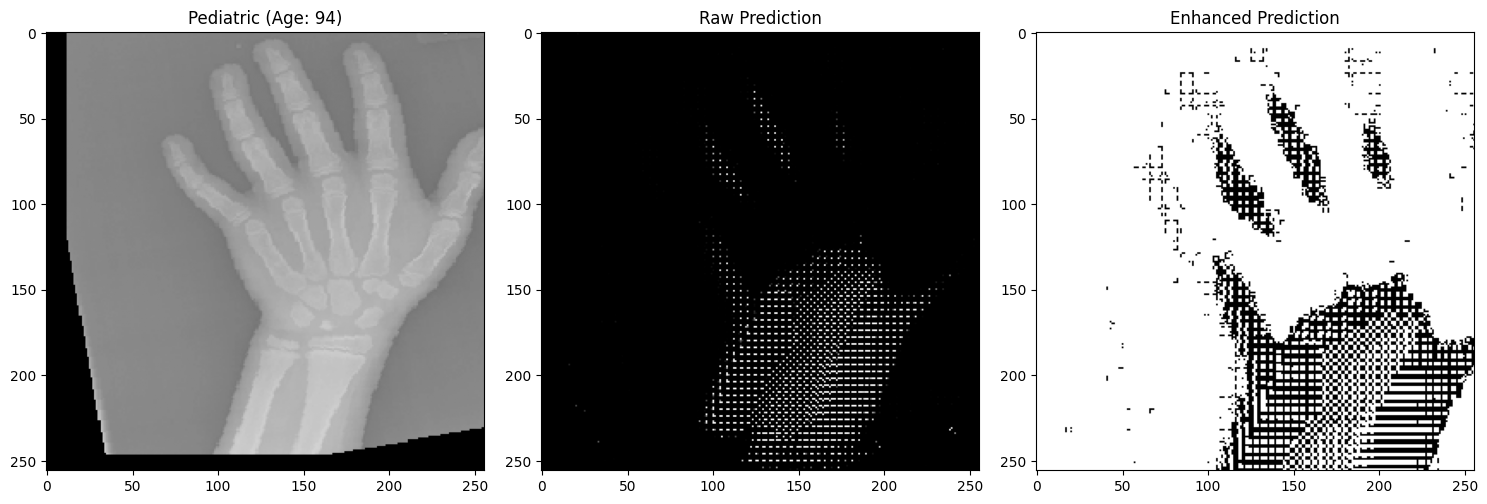

Age: 162 years, Sex: Male
Pediatric Measurements: [np.float64(133.8333809483805), np.float64(164.75626398601605), np.float64(0.3732030156887811), np.float64(62.216469596616996)]
Predicted Measurements: [np.float64(295.6010825419961), 0.0, np.float64(1.0), np.float64(295.6010825419961)]
Bone Length Growth: 120.9%


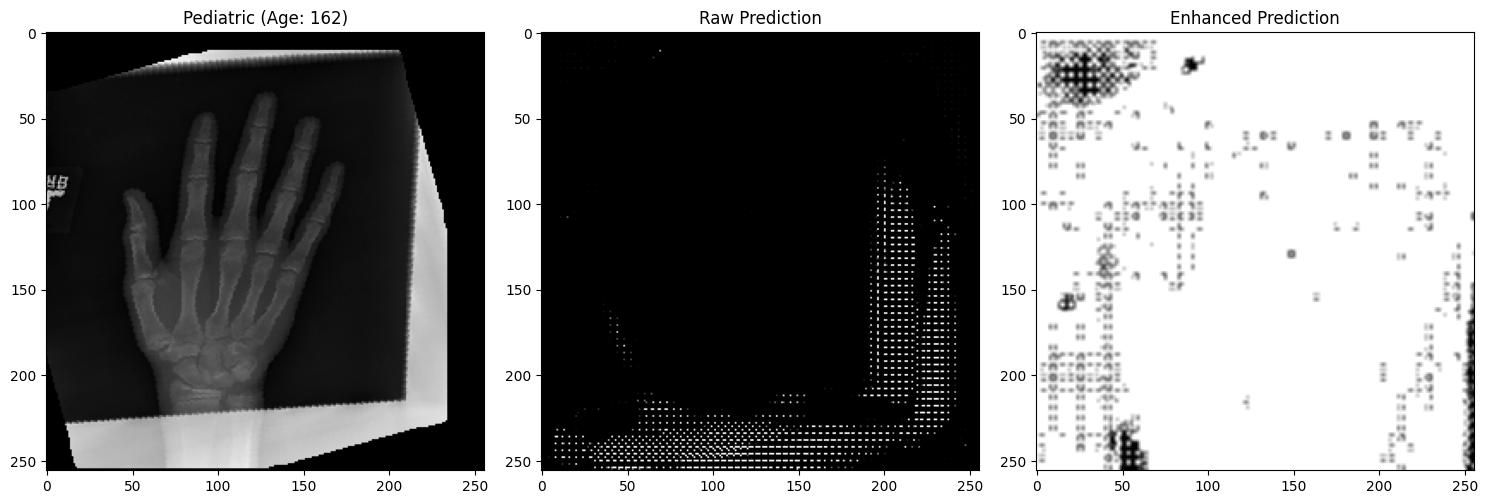

Age: 24 years, Sex: Female
Pediatric Measurements: [np.float64(175.46306422796204), np.float64(132.4392552196247), np.float64(0.6174595149831327), np.float64(121.05939295607965)]
Predicted Measurements: [np.float64(295.6010825419961), 0.0, np.float64(1.0), np.float64(295.6010825419961)]
Bone Length Growth: 68.5%


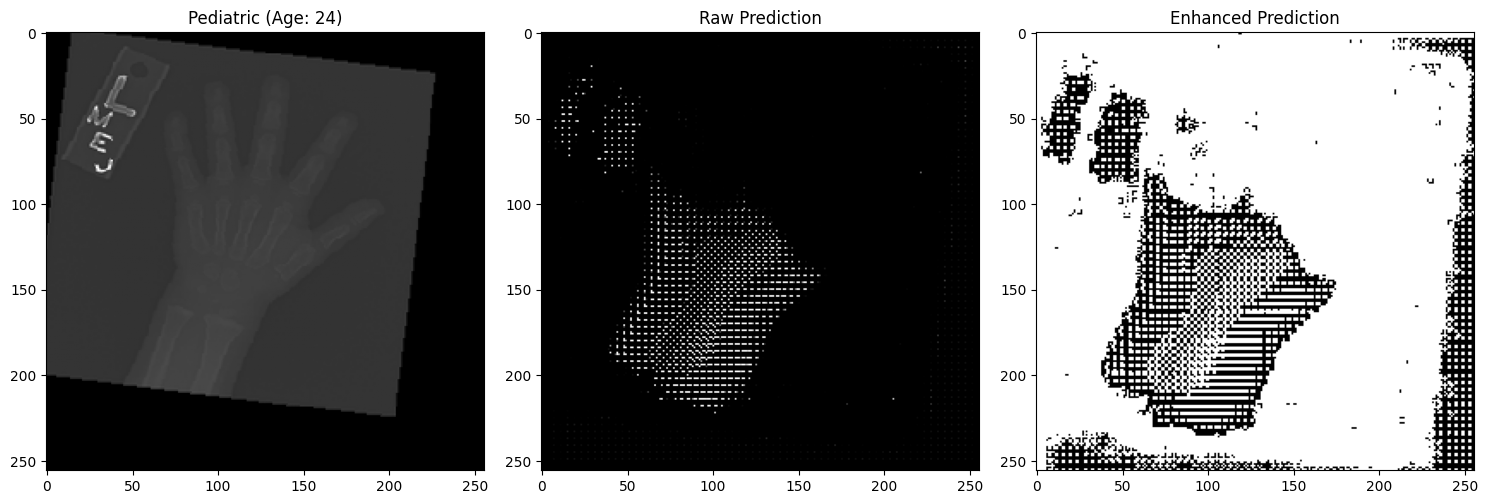

Age: 180 years, Sex: Male
Pediatric Measurements: [np.float64(299.4566801463294), 0.0, np.float64(0.9817287154734748), np.float64(293.9852219400072)]
Predicted Measurements: [np.float64(295.6010825419961), 0.0, np.float64(1.0), np.float64(295.6010825419961)]
Bone Length Growth: -1.3%


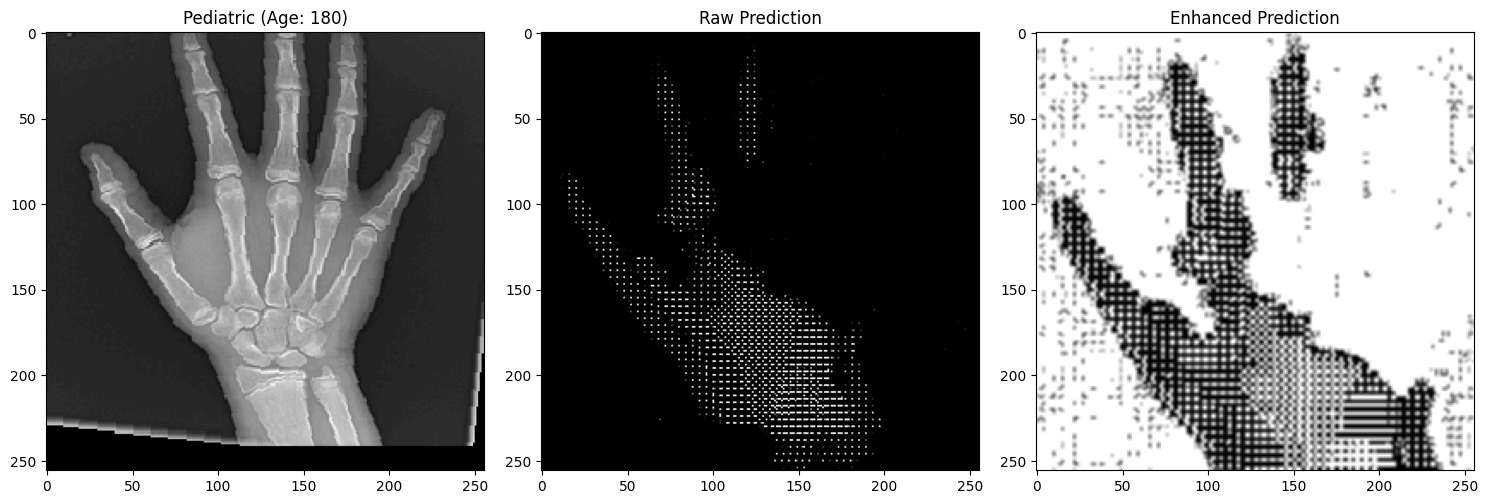

Age: 24 years, Sex: Male
Pediatric Measurements: [np.float64(187.80911827280175), np.float64(179.20962730215004), np.float64(0.3162592778111481), np.float64(78.74455317050561)]
Predicted Measurements: [np.float64(295.6010825419961), 0.0, np.float64(1.0), np.float64(295.6010825419961)]
Bone Length Growth: 57.4%


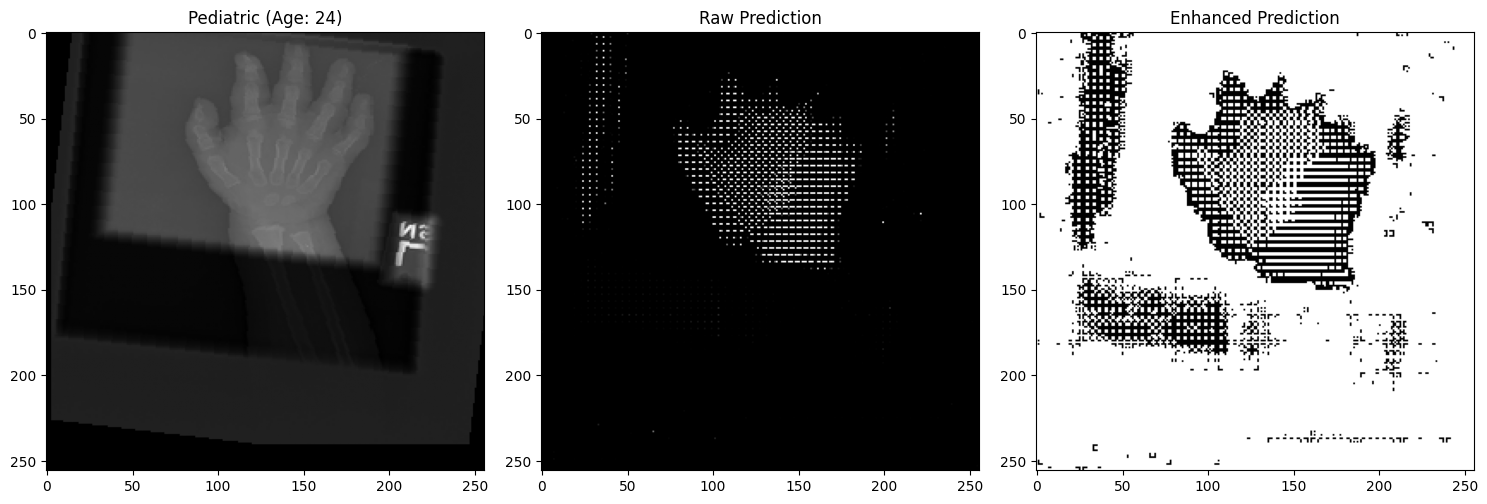

In [ ]:
if __name__ == "__main__":
    cache_dir = "/content/cached_images_256"
    dataset_path = kagglehub.dataset_download("kmader/rsna-bone-age") # Download dataset
    csv_file = os.path.join(dataset_path, "boneage-training-dataset.csv") # Set CSV file path
    img_dir = os.path.join(dataset_path, "boneage-training-dataset", "boneage-training-dataset")  # Set image directory
    MAX_SAMPLES = 300 # Set maximum samples

    if not os.path.exists(cache_dir) or len(os.listdir(cache_dir)) < len(pd.read_csv(csv_file)) * 2:
        preprocess_and_cache_dataset(csv_file, img_dir, cache_dir, max_samples=MAX_SAMPLES)

    try:
        dataset = BoneAgeDataset(csv_file, cache_dir=cache_dir)
        print(f"Dataset size: {len(dataset)} samples")
    except ValueError as e:
        print(f"Dataset initialization failed: {e}")
        dataset = BoneAgeDataset(csv_file, img_dir=img_dir)
        print(f"Fallback dataset size: {len(dataset)} samples")

    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    if train_size == 0 or val_size == 0:
        raise ValueError(f"Insufficient samples for split. Train: {train_size}, Val: {val_size}")

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True, collate_fn=collate_fn)

    generator = GeneratorResNet(param_dim=14, num_residual_blocks=12).to(DEVICE)
    discriminator = Discriminator().to(DEVICE)
    print("Starting with enhanced ResNet-based generator with adaptive normalization.")

    with torch.no_grad():
        dummy_pediatric = torch.clamp(torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE), -1, 1)
        dummy_params = torch.clamp(torch.randn(1, 14).to(DEVICE), -1, 1)
        gen_output = generator(dummy_pediatric, dummy_params)
        print(f"Initial Generator Output Min: {gen_output.min().item()}, Max: {gen_output.max().item()}")
        dummy_adult = torch.clamp(torch.randn(1, 1, IMG_SIZE, IMG_SIZE).to(DEVICE), -1, 1)
        disc_output = discriminator(dummy_adult, dummy_pediatric)
        print(f"Discriminator output shape: {disc_output.shape}")

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\nGenerator architecture:")
    print(generator)
    print(f"\nGenerator has {count_parameters(generator):,} trainable parameters")
    print("\nDiscriminator architecture:")
    print(discriminator)
    print(f"\nDiscriminator has {count_parameters(discriminator):,} trainable parameters")
    print("Model verification complete. Starting training...")

    optim_gen = optim.Adam(generator.parameters(), lr=LR, betas=(0.5, 0.999))
    optim_disc = optim.Adam(discriminator.parameters(), lr=LR, betas=(0.5, 0.999))
    criterion_gan = nn.MSELoss()
    combined_loss = CombinedLoss().to(DEVICE)
    scaler = GradScaler('cuda', enabled=torch.cuda.is_available())

    scheduler_gen = optim.lr_scheduler.ReduceLROnPlateau(optim_gen, mode='min', factor=0.5, patience=2)
    scheduler_disc = optim.lr_scheduler.ReduceLROnPlateau(optim_disc, mode='min', factor=0.5, patience=2)

    best_ssim = -1.0
    patience_counter = 0

    for epoch in range(0, EPOCHS):
        generator.train()
        discriminator.train()
        train_gen_loss = 0.0
        train_disc_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{EPOCHS}")

        for i, batch in enumerate(progress_bar):
            pediatric_imgs = batch['pediatric_img'].to(DEVICE)
            adult_imgs = batch['adult_img'].to(DEVICE)
            params = batch['params'].to(DEVICE)

            # Train Discriminator
            optim_disc.zero_grad()
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                fake_adults = generator(pediatric_imgs, params)
                real_pred = discriminator(adult_imgs, pediatric_imgs)
                fake_pred = discriminator(fake_adults.detach(), pediatric_imgs)
                disc_loss = -torch.mean(real_pred) + torch.mean(fake_pred)
                gp = gradient_penalty(discriminator, adult_imgs, fake_adults, DEVICE)
                disc_loss += 10 * gp

            scaler.scale(disc_loss).backward()
            scaler.step(optim_disc)
            scaler.update()

            # Train Generator
            optim_gen.zero_grad()
            with autocast(device_type='cuda', enabled=torch.cuda.is_available()):
                fake_adults_gen = generator(pediatric_imgs, params)
                valid = discriminator(fake_adults_gen, pediatric_imgs)
                gen_loss_gan = criterion_gan(valid, torch.ones_like(valid))
                gen_loss_combined = combined_loss(fake_adults_gen, adult_imgs, params)
                gen_loss = GAN_LAMBDA * gen_loss_gan + gen_loss_combined

                if torch.isnan(gen_loss) or torch.isinf(gen_loss):
                    print(f"NaN or Inf detected in gen_loss at batch {i}. Skipping optimizer step.")
                    continue

            scaler.scale(gen_loss).backward()  # Scale and backward pass
            scaler.unscale_(optim_gen)  # Update discriminator weights
            torch.nn.utils.clip_grad_norm_(generator.parameters(), max_grad_norm)
            scaler.step(optim_gen)
            scaler.update()

            train_gen_loss += gen_loss.item()
            train_disc_loss += disc_loss.item()
            progress_bar.set_postfix({'Gen Loss': f'{gen_loss.item():.4f}', 'Disc Loss': f'{disc_loss.item():.4f}'})

        # Validation
        generator.eval()
        val_loss = 0.0
        ssim_scores = []
        with torch.no_grad():
            for batch in val_loader:
                pediatric_imgs = batch['pediatric_img'].to(DEVICE)
                adult_imgs = batch['adult_img'].to(DEVICE)
                params = batch['params'].to(DEVICE)
                fake_adults = generator(pediatric_imgs, params)
                val_loss += combined_loss(fake_adults, adult_imgs, params).item()

                for i in range(fake_adults.size(0)):
                    fake_np = torch.clamp((fake_adults[i] + 1) / 2, 0, 1).cpu().numpy().squeeze()
                    real_np = torch.clamp((adult_imgs[i] + 1) / 2, 0, 1).cpu().numpy().squeeze()
                    if fake_np.size > 0 and real_np.size > 0:
                        ssim_score = ssim(fake_np, real_np, data_range=1.0)
                        ssim_scores.append(ssim_score)
                    else:
                        ssim_scores.append(0.0)

        avg_train_gen_loss = train_gen_loss / len(train_loader) if train_gen_loss > 0 else 0.0
        avg_train_disc_loss = train_disc_loss / len(train_loader) if train_disc_loss > 0 else 0.0
        avg_val_loss = val_loss / len(val_loader) if val_loss > 0 else 0.0
        avg_ssim = sum(ssim_scores) / len(ssim_scores) if ssim_scores else 0.0

        print(f"Epoch {epoch+1}/{EPOCHS} | Gen Loss: {avg_train_gen_loss:.4f} | Disc Loss: {avg_train_disc_loss:.4f} | Val Loss: {avg_val_loss:.4f} | SSIM: {avg_ssim:.4f}")

        # Update learning rate schedulers
        old_lr_gen = optim_gen.param_groups[0]['lr']
        old_lr_disc = optim_disc.param_groups[0]['lr']
        scheduler_gen.step(avg_val_loss)
        scheduler_disc.step(avg_val_loss)

        if optim_gen.param_groups[0]['lr'] != old_lr_gen:
            print(f"Generator learning rate reduced to {optim_gen.param_groups[0]['lr']}")
        if optim_disc.param_groups[0]['lr'] != old_lr_disc:
            print(f"Discriminator learning rate reduced to {optim_disc.param_groups[0]['lr']}")

        # Save checkpoints
        if (epoch + 1) % 5 == 0 or epoch == EPOCHS - 1:
            torch.save({"generator": generator.state_dict(), "discriminator": discriminator.state_dict(), "epoch": epoch}, "model_checkpoint.pth")
            print(f"Saved checkpoint at epoch {epoch + 1}")

        # Save best model
        if avg_ssim > best_ssim and not np.isnan(avg_ssim):
            best_ssim = avg_ssim
            torch.save(generator.state_dict(), "best_generator.pth")
            torch.save(discriminator.state_dict(), "best_discriminator.pth")
            print("Saved best model")
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    # Save final models
    torch.save(generator.state_dict(), "final_generator.pth")
    torch.save(discriminator.state_dict(), "final_discriminator.pth")

    # Export predictions
    compute_predictions_for_export(generator, dataset, num_samples=100)

    # Visualize predictions
    for idx in [0, 10, 20, 30, 40]:
        predict_adult_bone(generator, dataset, idx=idx)